## pret-raind VGG16を利用

In [1]:
from keras.applications.vgg16 import VGG16

Using TensorFlow backend.


In [2]:
model = VGG16(include_top=False, weights='imagenet')  # 出力層側にある3つの全結合層は使用しない
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [3]:
import pandas as pd
data_df = pd.read_csv('../outputs/target_idx.csv')
data_df.head()

,Image Index,Emphysema
0,00000009_000.png,1
1,00000013_041.png,1
2,00000013_042.png,1
3,00000027_000.png,1
4,00000034_000.png,1


In [4]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rescale=1. / 255.)

img_dir = "../inputs/images/"

generator = datagen.flow_from_dataframe(
                            dataframe=data_df,
                            directory=img_dir,
                            x_col="Image Index",
                            y_col="Emphysema",
                            has_ext=True,                                      
                            subset="training",
                            batch_size=32,
                            seed=1,
                            shuffle=False,
                            color_mode = 'rgb',
                            class_mode="binary",
                            target_size=(512, 512))

Found 1892 images belonging to 2 classes.


### NIH Datasetを入力とし、VGG16のbottleneck_featuresを出力

In [20]:
train_samples = len(data_df.index)
# bottleneck_features_train = model.predict_generator(generator, train_samples)
# print(bottleneck_features_train.shape)
bottleneck_features_train = model.predict_generator(generator, train_samples//32)
print(bottleneck_features_train.shape)

(1888, 16, 16, 512)


In [22]:
true_labels = generator.classes[:bottleneck_features_train.shape[0]]

In [39]:
import numpy as np
np.savez('../pre-trained/bottleneck_features_train_VGG16' , x=bottleneck_features_train, y=true_labels)

In [5]:
import numpy as np
npy = np.load('../pre-trained/bottleneck_features_train_VGG16.npz')
bottleneck_features_train = npy['x']
true_labels = npy['y']

### 全結合層を構築

In [6]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import optimizers

In [7]:
model = Sequential()
model.add(Flatten(input_shape=bottleneck_features_train.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),             
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33554688  
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 33,554,945
Trainable params: 33,554,945
Non-trainable params: 0
_________________________________________________________________


### 訓練データと評価データに分割

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(bottleneck_features_train, true_labels, test_size=0.1, random_state=0)
print(X_train.shape)

(1699, 16, 16, 512)


### 学習

In [9]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_test, y_test))

Train on 1699 samples, validate on 189 samples
Epoch 1/10
1699/1699 [==============================] - 6s 4ms/step - loss: 0.7261 - acc: 0.5197 - val_loss: 0.6857 - val_acc: 0.5661
Epoch 2/10
1699/1699 [==============================] - 6s 4ms/step - loss: 0.6966 - acc: 0.5368 - val_loss: 0.6915 - val_acc: 0.5132
Epoch 3/10
1699/1699 [==============================] - 6s 4ms/step - loss: 0.6849 - acc: 0.5480 - val_loss: 0.6944 - val_acc: 0.5132
Epoch 4/10
1699/1699 [==============================] - 6s 4ms/step - loss: 0.6853 - acc: 0.5603 - val_loss: 0.6851 - val_acc: 0.5397
Epoch 5/10
1699/1699 [==============================] - 6s 4ms/step - loss: 0.6772 - acc: 0.5662 - val_loss: 0.6771 - val_acc: 0.6190
Epoch 6/10
1699/1699 [==============================] - 6s 4ms/step - loss: 0.6795 - acc: 0.5697 - val_loss: 0.6787 - val_acc: 0.6349
Epoch 7/10
1699/1699 [==============================] - 6s 4ms/step - loss: 0.6822 - acc: 0.5656 - val_loss: 0.6794 - val_acc: 0.5820
Epoch 8/10
1699

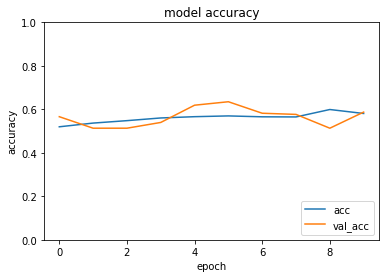

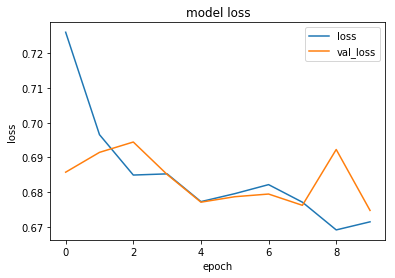

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_history(history):
    # print(history.history.keys())

    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.ylim(0, 1.0)
    plt.legend(['acc', 'val_acc'], loc='lower right')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['loss', 'val_loss'], loc='upper right')
    plt.show()

plot_history(history)

In [11]:
np.savez('../plots/Bottleneck_features(VGG16)_train', acc=history.history['acc'], loss=history.history['loss'])
np.savez('../plots/Bottleneck_features(VGG16)_valid', acc=history.history['val_acc'], loss=history.history['val_loss'])